# PARAMETERS

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


### parameters ###
L, T = 1, 2
dx = 0.01
c, CFL = 1, 1.0

N_x = int(L/dx)
x = np.linspace(-L/2, L/2, N_x)

dt = CFL * dx
N_t = int(T/dt)

### initial and periodic boundary condition ###
def initial_condition(x):
    u_initial = np.zeros_like(x)
    width, height, center = 0.2, 1, 0
    u_initial = height * (np.heaviside(x - center + width/2, 1)-np.heaviside(x - center - width/2, 1))
    return u_initial

def periodic_boundary_condition(u):
    u[0] = u[-1]
    u[-1] = u[0]
    return u

### The discretized flux ###
def F(u, dx, c):
    # u = periodic_boundary_condition(u)
    du_dx = np.zeros_like(u)
    du_dx[1:-1] = (u[2:] - u[:-2]) / (2 * dx)

    du_dx[0] = (u[1] - u[-1]) / (2*dx)  # Forward difference for the first point
    du_dx[-1] = (u[0] - u[-2]) / (2*dx)  # Backward difference for the last point


    # du_dx[0] = (u[1] - u[0]) / dx  # Forward difference for the first point
    # du_dx[-1] = (u[-1] - u[-2]) / dx  # Backward difference for the last point
    return -c * du_dx

### Create the animation and plot ###
def plot(x,utx, title, params, dt, save_anim=False):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, utx[0])

    line, = ax.plot(x, utx[0])
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_title(title)
    ax.set_ylim(-0.2, 1.2)  # Set y-axis limits based on expected solution range

    def update(frame):
        line.set_ydata(utx[frame])
        ax.set_title(f"{title} (t = {frame * dt:.4f})\n{params}")
        return line,

    anim = animation.FuncAnimation(fig, update, frames=len(utx), interval=100, blit=True)

    # Save the animation (optional)
    if save_anim:
        anim.save('burgers_solution.gif', writer='pillow')

    ax.plot(x, utx[-1])
    plt.show()


# NO FILTERING

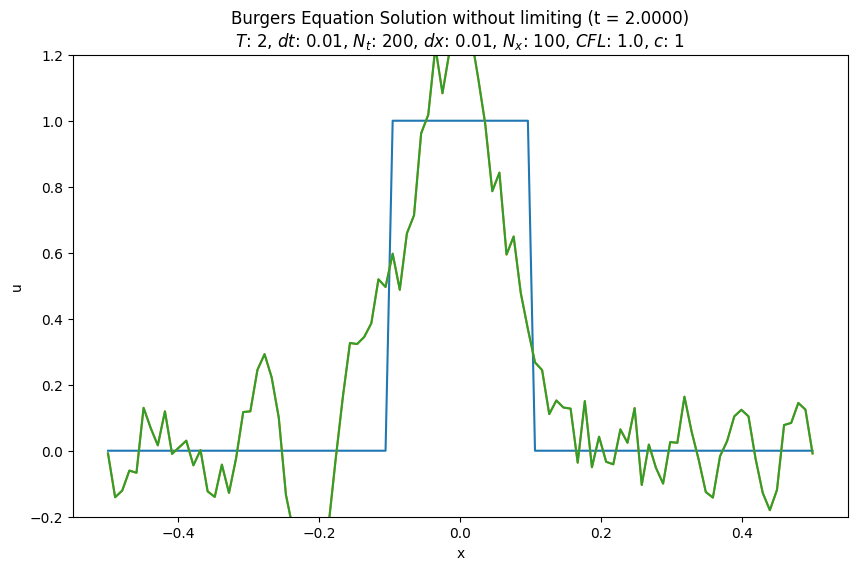

In [6]:
### RK4 ###
def RK4(u, dx, c, dt):
    k1 = F(u, dx, c)
    k2 = F(u + 0.5 * dt * k1, dx, c)
    k3 = F(u + 0.5 * dt * k2, dx, c)
    k4 = F(u + dt * k3, dx, c)
    return u + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

### Burgers equation: du/dt = -c * du/dx = F(u, dx, c) ###
def solve_Burgers(u_initial, dx, c, dt, N_t):
    utx = [u_initial.copy()]
    for _ in range(N_t):
        u = RK4(utx[-1], dx, c, dt)
        utx.append(u.copy())
    return utx

### main ###
u_initial = initial_condition(x)
utx = solve_Burgers(u_initial, dx, c, dt, N_t)

title = "Burgers Equation Solution without limiting"
params = f"$T$: {T}, $dt$: {dt}, $N_t$: {N_t}, $dx$: {dx}, $N_x$: {N_x}, $CFL$: {CFL}, $c$: {c}"
plot(x, utx, title, params, dt, save_anim=False)


# USING FILTER

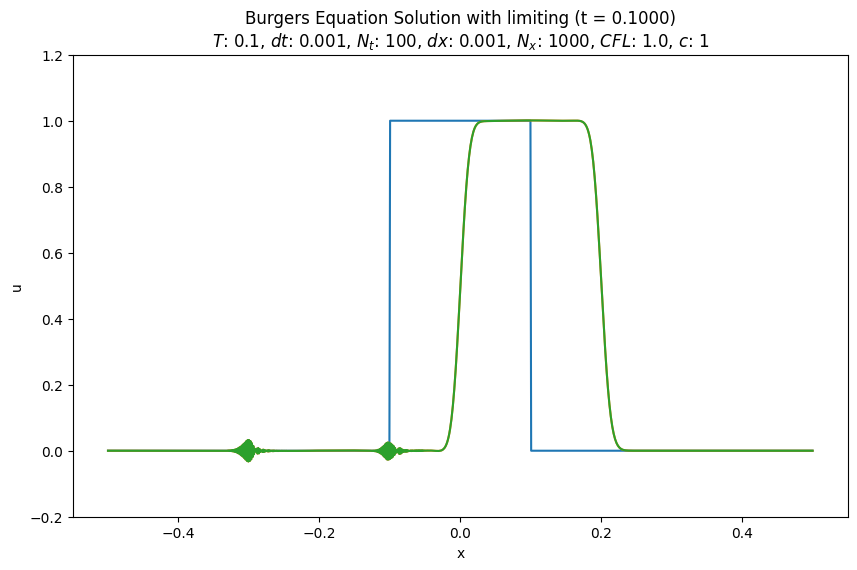

In [6]:
def superbee_limiter(r):
    """
    Superbee limiter to reduce Gibbs oscillations
    
    Parameters:
    -----------
    r : float or numpy array
        Ratio of consecutive gradients
    
    Returns:
    --------
    Limited slope
    """
    return np.maximum(0, np.maximum(np.minimum(2*r, 1), np.minimum(r, 2)))

def compute_limiter(u):
    """
    Compute slope limiter for the solution
    
    Parameters:
    -----------
    u : numpy array
        Solution array
    
    Returns:
    --------
    Limited solution
    """
    # Compute forward and backward differences
    du_forward = np.zeros_like(u)
    du_backward = np.zeros_like(u)
    
    # Forward differences
    du_forward[:-1] = u[1:] - u[:-1]
    du_forward[-1] = u[0] - u[-1]  # Periodic boundary
    
    # Backward differences
    du_backward[1:] = u[1:] - u[:-1]
    du_backward[0] = u[0] - u[-1]  # Periodic boundary
    
    # Compute ratios (avoid division by zero)
    eps = 1e-10
    r_forward = np.abs(du_backward) / (np.abs(du_forward) + eps)
    r_backward = np.abs(du_forward) / (np.abs(du_backward) + eps)
    
    # Apply superbee limiter
    phi_forward = superbee_limiter(r_forward)
    phi_backward = superbee_limiter(r_backward)
    
    # Limited solution
    u_limited = u.copy()
    u_limited[1:-1] = u[1:-1] - 0.5 * phi_forward[1:-1] * du_forward[1:-1]
    
    return u_limited

# Modify the RK4 function to include limiting
def RK4_limited(u, dx, c, dt):
    """
    RK4 method with slope limiting to reduce Gibbs oscillations
    """
    k1 = F(u, dx, c)
    k1_limited = compute_limiter(k1)
    
    k2 = F(u + 0.5 * dt * k1_limited, dx, c)
    k2_limited = compute_limiter(k2)
    
    k3 = F(u + 0.5 * dt * k2_limited, dx, c)
    k3_limited = compute_limiter(k3)
    
    k4 = F(u + dt * k3_limited, dx, c)
    k4_limited = compute_limiter(k4)
    
    return u + (dt/6) * (k1_limited + 2*k2_limited + 2*k3_limited + k4_limited)

# Replace the original RK4 call in solve_Burgers with RK4_limited
def solve_Burgers_limited(u_initial, dx, c, dt, N_t):
    utx = [u_initial.copy()]
    for _ in range(N_t):
        u = RK4_limited(utx[-1], dx, c, dt)
        utx.append(u.copy())
    return utx

### main ###
u_initial = initial_condition(x)
utx = solve_Burgers_limited(u_initial, dx, c, dt, N_t)

title = "Burgers Equation Solution with limiting"
params = f"$T$: {T}, $dt$: {dt}, $N_t$: {N_t}, $dx$: {dx}, $N_x$: {N_x}, $CFL$: {CFL}, $c$: {c}"
plot(x, utx, title, params, dt, save_anim=False)


## 2. Description of the sensor and the nonlinear filter

Following the filter form introduced in [10], we write the numerical filter equation in the conservative form:

$$
\widetilde{U}_{j}^{n+1} = U_{j}^{n+1} + \frac{\Delta t}{\Delta x} \left( \widetilde{F}_{j+1/2} - \widetilde{F}_{j-1/2} \right),
$$

where \(\Delta t\) is the time-step and \(\Delta x\) is the grid spacing. For a \(2m\)th-order explicit linear filter (Appendix A) we have:

$$
\widetilde{F}_{j+1/2}^{(m)} = (-1)^{m-1} e^{(m)} (\Delta \nabla)^{m-1} \Delta U_j,
$$

where \(e^{(m)}\) is the dissipation coefficient and \(\Delta\) and \(\nabla\) are the forward and backward difference operators, which are defined by, respectively:

$$
\Delta U_j = U_{j+1} - U_j, \quad \nabla U_j = U_j - U_{j-1}.
$$

Substitution of (2) in (1) yields:

$$
\widetilde{U}_{j}^{n+1} = U_{j}^{n+1} + \frac{\Delta t}{\Delta x} (-1)^{m-1} e^{(m)} (\Delta \nabla)^{m} U_{j}^{n+1}.
$$

Choosing \((\Delta t / \Delta x) e^{(m)} = 1 / 4^{m}\) causes the filter to eliminate the wave with the highest frequency resolvable in a given grid (\(\omega = \pi / \Delta x\), see Appendix A). Note that it is possible to omit \(\Delta t / \Delta x\) in the filter Eq. (1), but it is better to keep it in order to have a consistent filter with the discretized governing equation when using different values for \(\Delta t\) and \(\Delta x\).

There are good reasons that the second-order linear filter is suitable for discontinuous regions which is not the case for the higher-order linear filters. On the other hand, the high-order linear filters have desirable properties in smooth regions. Consequently, it is desirable to have a nonlinear filter which acts as a second-order linear filter near the discontinuities and behaves as a high-order linear filter in smooth regions [13,14]. In this regard, we write the numerical filter flux as a combination of the second- and a higher-order filter flux:

$$
\widetilde{F} = \omega_1 \widetilde{F}^{(1)} + \omega_m \widetilde{F}^{(m)}, \quad m > 1,
$$

where \(\omega_1\) and \(\omega_m\) are the nonlinear weights controlling the amount of the second and \(2m\)th-order filters. The proper design of these weights is essential to have high accuracy in smooth regions and to obtain non-oscillatory sharp discontinuities.